In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft, ifft, fftfreq

# Ładowanie obrazów
def load_image(file_path):
    image = Image.open(file_path).convert('L')
    return np.array(image)

# Transformacja Radona
def radon_transform(image, delta_alpha, n_detectors, spread):
    h, w = image.shape
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    s = np.linspace(-spread/2, spread/2, n_detectors)
    sinogram = np.zeros((len(angles), n_detectors))
    
    for i, theta in enumerate(angles):
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)
        
        for j, s_val in enumerate(s):
            line_sum = 0.0
            x0 = (s_val - (-h//2 * sin_t)) / cos_t if abs(cos_t) > 1e-6 else s_val / 1e-6
            y0 = (-h//2)
            x1 = (s_val - (h//2 * sin_t)) / cos_t if abs(cos_t) > 1e-6 else s_val / 1e-6
            y1 = h//2
            
            for x, y in bresenham_line(int(x0 + w//2), int(y0 + h//2), int(x1 + w//2), int(y1 + h//2)):
                if 0 <= x < w and 0 <= y < h:
                    line_sum += image[y, x]
            
            sinogram[i, j] = line_sum
    
    return sinogram

# Filtracja sinogramu
def apply_filter(sinogram):
    num_projections, num_detectors = sinogram.shape
    freqs = fftfreq(num_detectors)
    filter_kernel = np.abs(freqs)

    filter_kernel = filter_kernel.reshape(1, -1)
    sinogram_fft = fft(sinogram, axis=1)
    filtered_sinogram = np.real(ifft(sinogram_fft * filter_kernel, axis=1))
    
    return filtered_sinogram

# Odwrotna transformacja Radona
def inverse_radon_transform(sinogram, delta_alpha):
    h, w = sinogram.shape[1], sinogram.shape[1]
    reconstructed = np.zeros((h, w))    
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    center = w // 2

    for i, theta in enumerate(angles):
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        
        for x in range(w):
            for y in range(h):
                s = (x - center) * cos_t + (y - center) * sin_t
                s_idx = int(s + sinogram.shape[1] // 2)
                
                if 0 <= s_idx < sinogram.shape[1]:
                    reconstructed[y, x] += sinogram[i, s_idx]
    
    return reconstructed / len(angles)

# Algorytm Bresenhama
def bresenham_line(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    line = []
    
    while True:
        line.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return line

# Główna funkcja przetwarzająca obraz
def process_image(file_path, delta_alpha, n_detectors, spread):
    image_array = load_image(file_path)
    sinogram = radon_transform(image_array, delta_alpha, n_detectors, spread)
    filtered_sinogram = apply_filter(sinogram)
    reconstructed_image_without_filter = inverse_radon_transform(sinogram, delta_alpha)
    reconstructed_image_with_filter = inverse_radon_transform(filtered_sinogram, delta_alpha)
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(image_array, cmap='gray')
    axs[0].set_title("Oryginalny obraz")
    axs[1].imshow(sinogram, cmap='gray', aspect='auto')
    axs[1].set_title("Sinogram")
    axs[2].imshow(filtered_sinogram, cmap='gray', aspect='auto')
    axs[2].set_title("Filtrowany sinogram")
    axs[3].imshow(reconstructed_image_without_filter, cmap='gray')
    axs[3].set_title("Obraz po odwrotnej transformacji bez filtru")
    axs[4].imshow(reconstructed_image_with_filter, cmap='gray')
    axs[4].set_title("Obraz po odwrotnej transformacji")
    
    plt.show()


Uruchamianie na różnych obrazach

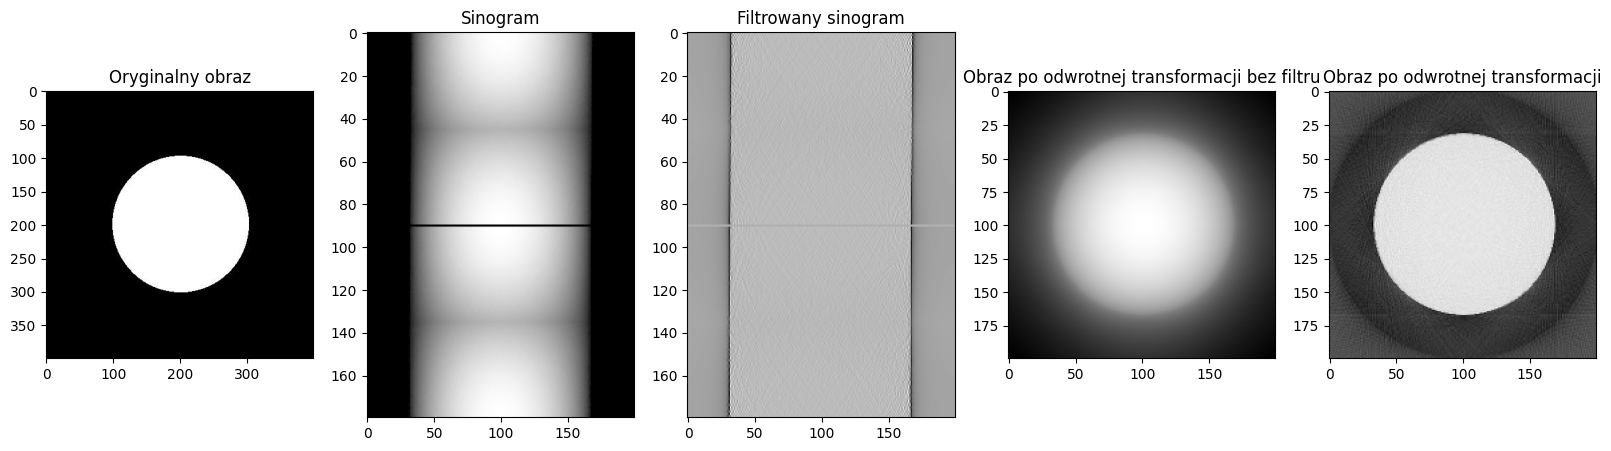

In [3]:
file_path = "tomograf-obrazy/Kolo.jpg"
process_image(file_path, delta_alpha=1, n_detectors=200, spread=300)

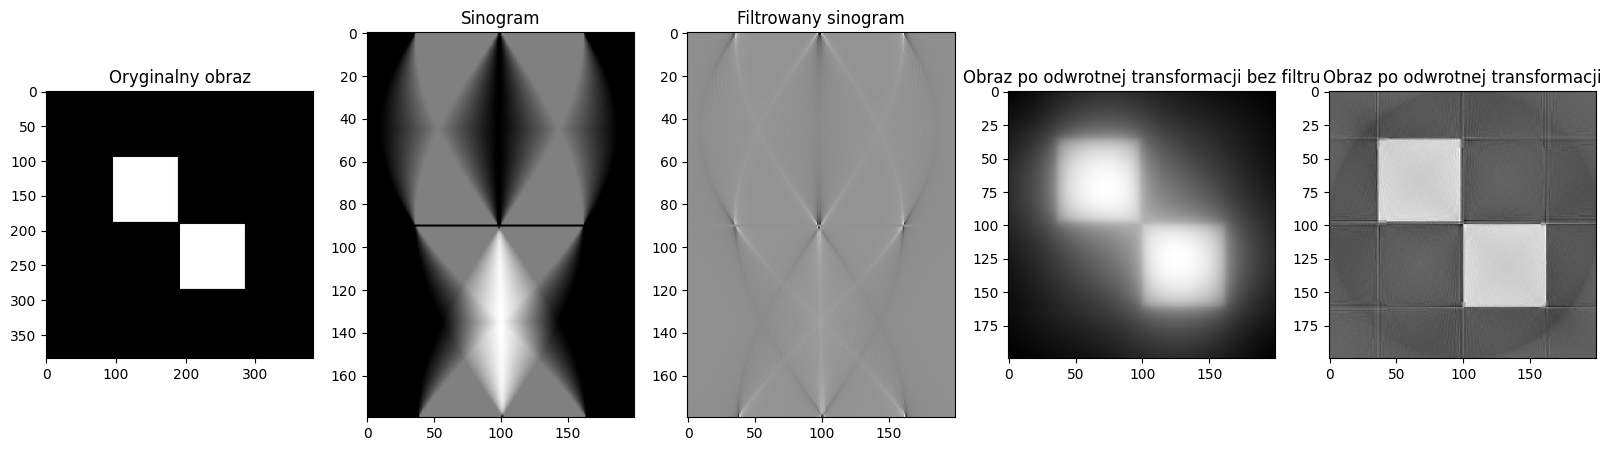

In [4]:
file_path = "tomograf-obrazy/Kwadraty2.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

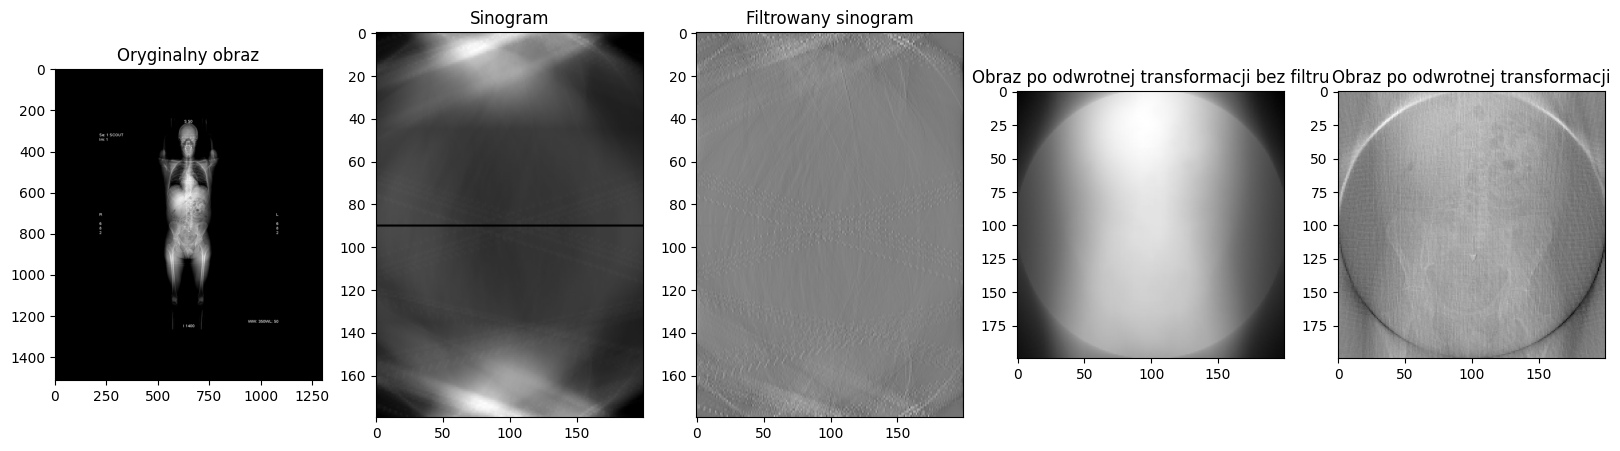

In [5]:
file_path = "tomograf-obrazy/CT_ScoutView-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

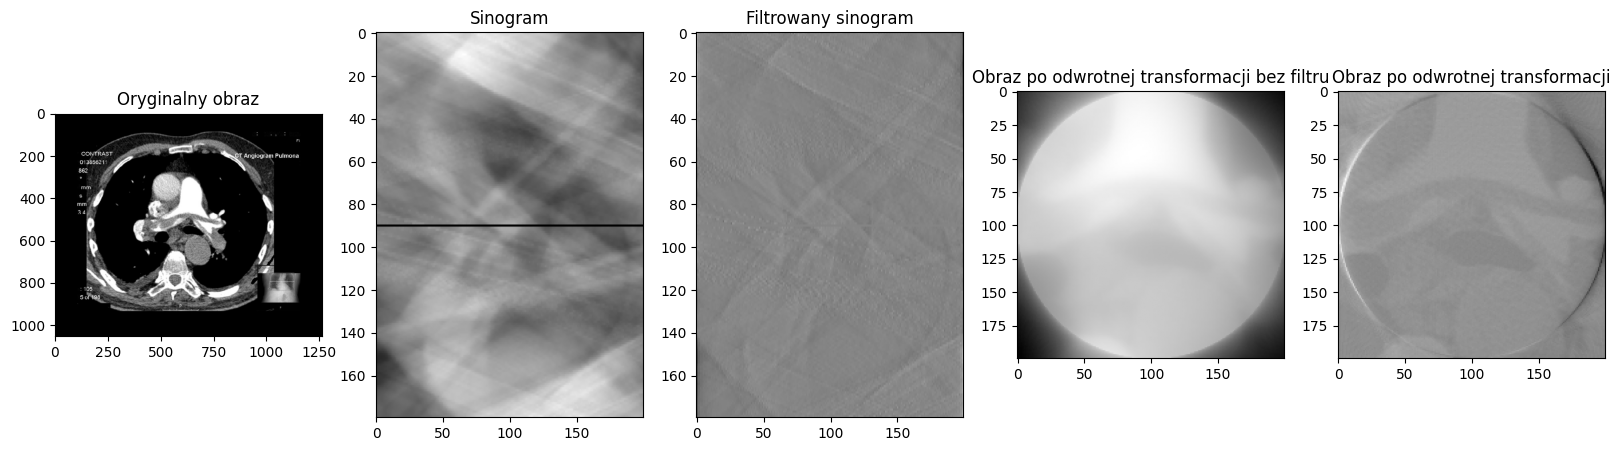

In [6]:
file_path = "tomograf-obrazy/SADDLE_PE-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

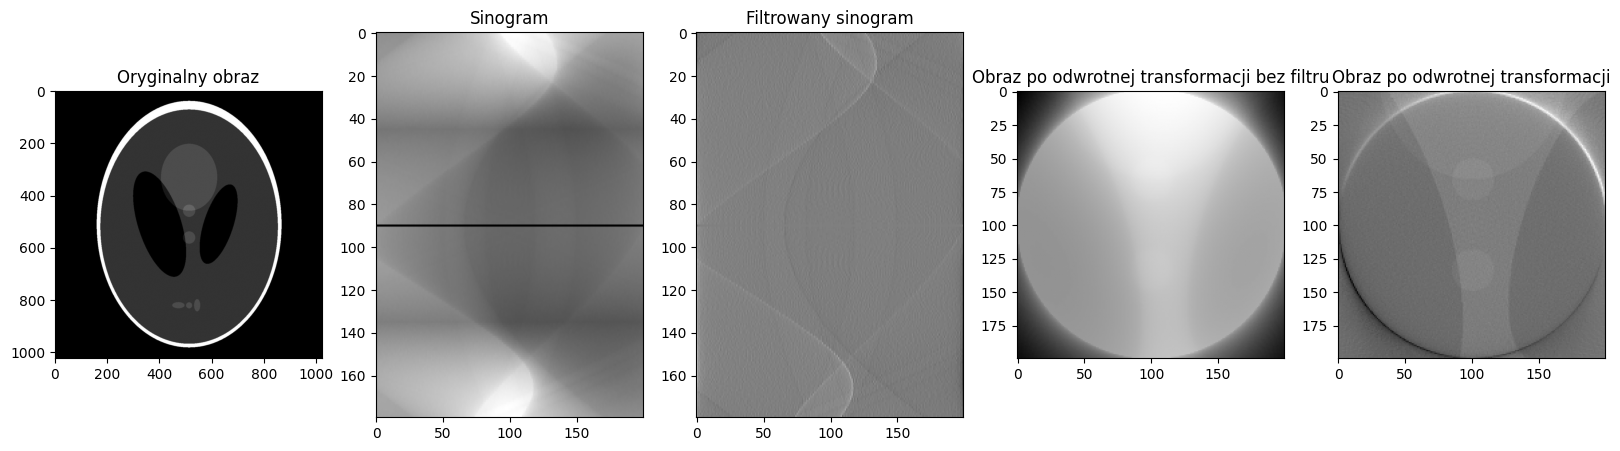

In [7]:
file_path = "tomograf-obrazy/Shepp_logan.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)